# SWM mapping using 7T qMRI

### Libraries

In [15]:
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import numpy as np
import seaborn as sns
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
import matplotlib as mpl

### Load surfaces and masks

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Boolean mask
mask_surf = mask_5k != 0

### Functions

## F1: Surface-based intensity smoothing and processing for qMRI data

In [ ]:
# Function: Smooth intensity profiles on a given surface
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    Smooths intensity data on a given surface mesh using iterative smoothing.
    
    Parameters:
    -----------
    surf_l : np.array
        Left hemisphere surface connectivity.
    surf_r : np.array
        Right hemisphere surface connectivity.
    points : np.array
        Intensity profile data mapped to the surface.
    Mask : np.array
        Binary mask indicating valid regions for smoothing.
    Kernel : str, optional
        Smoothing kernel type, options: {'uniform', 'gaussian', 'inverse_distance'}.
    Niter : int, optional
        Number of smoothing iterations (default: 3).
    Relax : float, optional
        Relaxation factor controlling smoothing intensity (default: 0.35).
    
    Returns:
    --------
    sdata : np.array
        Smoothed intensity data.
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l = Mask[:n2dim]
    Mask_r = Mask[n2dim:]
    
    sdata = np.concatenate((
        smooth_array(surf_l, points[:n2dim], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_l), 
        smooth_array(surf_r, points[n2dim:], kernel=Kernel, n_iter=Niter, relax=Relax, mask=Mask_r)
    ), axis=0)
    
    return sdata

# Function: Apply smoothing to intensity profiles across all depths
def smooth_intensities(int_profile):
    '''
    Applies surface smoothing to each depth of the intensity profile.
    
    Parameters:
    -----------
    int_profile : np.array
        Input intensity profiles, where rows represent different depths.
    
    Returns:
    --------
    smoothed_i : np.array
        Smoothed intensity profiles.
    '''
    smoothed_i = np.copy(int_profile)
    
    for i in range(int_profile.shape[0]):
        smoothed_i[i, :] = smooth_surf(
            inf_lh, inf_rh, int_profile[i, :], mask_surf, Niter=5, Relax=0.5, Kernel='uniform'
        )
    
    return smoothed_i

## F2: Microstructural profile by SWM depth

In [5]:
# Function: Load qMRI intensity profiles from preprocessed dataset
def load_qmri_intensity(qmri='', verbose=False):
    '''
    Loads qMRI intensity profiles from a predefined dataset directory.
    
    Parameters:
    -----------
    qmri : str
        The qMRI modality to load (e.g., 'T1map', 'MTSAT_protocol').
    verbose : bool, optional
        Whether to print detailed information about loaded files (default: False).
    
    Returns:
    --------
    profiles : np.array
        Loaded and smoothed intensity profiles.
    '''
    csv_dir = '/host/percy/local_raid/youngeun/from_mica1/lists'
    csv_file = f"10PNC_{qmri}.csv"
    subject_session_info = pd.read_csv(
        f"{csv_dir}/{csv_file}", header=None, names=['info'], delimiter=',')
    
    files = []
    for index, row in subject_session_info.iterrows():
        info = row['info'].split(',')
        subject = index[4:]  # Extract subject ID
        session = info[0][4:].strip()  # Extract session ID
        file_path = f"sub-{subject}/ses-{session}/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii"
        files.extend(glob.glob(file_path))
    
    if verbose:
        print("Files used:")
        for file_path in files:
            print(file_path)
    
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        profile_data_i = smooth_intensities(profile_data)
        profile_data_i[:, mask_5k == False] = np.nan  # Mask invalid regions
        profiles.append(profile_data_i)
    
    profiles = np.array(profiles)
    
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID
        subjects.add(subject)
    
    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")
    
    return profiles

# Function: Process multiple qMRI intensity profiles and return results
def process_qmri_profiles():
    '''
    Loads and processes qMRI intensity profiles for multiple modalities.
    
    Returns:
    --------
    T1map : np.array
        Smoothed intensity profiles for T1 maps.
    MTSAT : np.array
        Smoothed intensity profiles for MTSAT protocol.
    '''
    qmri_values = ['T1map', 'MTSAT_protocol']
    
    T1map, MTSAT = None, None
    
    for qmri in qmri_values:
        profiles = load_qmri_intensity(qmri)
        if qmri == 'T1map':
            T1map = profiles
        elif qmri == 'MTSAT_protocol':
            MTSAT = profiles
    
    return T1map, MTSAT

## F3: Ridge plot for visualizing qMRI intensity distributions

In [13]:
# Function: Generate a ridge plot to visualize intensity distributions across subjects

def plot_ridgeplot(matrix, matrix_df=None, Cmap='rocket', Range=(2.5, 4.5), Xlab="flair", save_path=None, title=None):
    '''
    Creates a ridge plot (stacked density plots) to visualize intensity distributions across different subjects.
    
    Parameters:
    -----------
    matrix : np.array
        Input intensity profile matrix, where each row represents a subject.
    matrix_df : list, optional
        Labels corresponding to each row of the matrix (e.g., subject IDs).
    Cmap : str, optional
        Colormap for the visualization (default: 'rocket').
    Range : tuple, optional
        X-axis limits (default: (2.5, 4.5)).
    Xlab : str, optional
        X-axis label (default: "flair").
    save_path : str, optional
        If provided, saves the figure to the specified path instead of displaying it.
    title : str, optional
        Title for the entire plot.
    '''
    
    # Flatten intensity matrix and prepare subject and ID labels
    ai = matrix.flatten()
    subject = np.array([])
    id_x = np.array([])
    
    for i in range(matrix.shape[0]):
        label = np.array([str(i+1) for j in range(matrix.shape[1])])
        subject = np.concatenate((subject, label))
        id_label = np.array([matrix_df[i] for j in range(matrix.shape[1])])
        id_x = np.concatenate((id_x, id_label))
    
    # Create DataFrame for plotting
    df = pd.DataFrame({
        'feature': ai,
        'subject': subject,
        'id_x': id_x
    })
    
    # Initialize figure and axes for ridge plot
    f, axs = plt.subplots(nrows=matrix.shape[0], figsize=(3.468504*2.5, 2.220472*3.5), sharex=True, sharey=True)
    f.set_facecolor('none')
    
    x = np.linspace(Range[0], Range[1], 100)  # Define x-axis range
    
    for i, ax in enumerate(axs, 1):
        # Plot density estimation
        sns.kdeplot(df[df["subject"]==str(i)]['feature'],
                    fill=True,
                    color="w",
                    alpha=0.25,
                    linewidth=1.5,
                    legend=False,
                    ax=ax)
        
        ax.set_xlim(Range[0], Range[1])
        
        # Overlay colormap
        im = ax.imshow(np.vstack([x, x]),
                       cmap=Cmap,
                       aspect="auto",
                       extent=[*ax.get_xlim(), *ax.get_ylim()]
                      )
        
        # Clip colormap to density shape
        path = ax.collections[0].get_paths()[0]
        patch = mpl.patches.PathPatch(path, transform=ax.transData)
        im.set_clip_path(patch)
        
        # Remove unnecessary plot borders
        ax.spines[['left','right','bottom','top']].set_visible(False)
        
        # Hide x-axis ticks except for the last plot
        if i != matrix.shape[0]:
            ax.tick_params(axis="x", length=0)
        else:
            ax.set_xlabel(Xlab)
        
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.axhline(0, color="black")
        ax.set_facecolor("none")
    
    # Add subject labels to the left side of each plot
    for i, ax in enumerate(axs):
        if i == matrix.shape[0] - 1:
            ax.set_xticks([Range[0], Range[1]])  # Set x-axis ticks for the bottom plot
        else:
            ax.set_xticks([])  # Remove x-axis ticks from other plots
        ax.text(0.05, 0.01, matrix_df[i], transform=ax.transAxes, fontsize=10, color='black', ha='left', va='bottom')
    
    plt.subplots_adjust(hspace=-0.8)  # Adjust spacing between plots
    
    # Add title if provided
    if title:
        plt.suptitle(title, y=0.99, fontsize=16)
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    else:
        plt.show()


## F4: Plot intensity profiles

In [25]:
def plot_filtered_pcolormesh(data, mask, color_range=(1050, 1400), figsize=(15, 8), cmap='gray'):
    """
    Plot a filtered pcolormesh after removing NaN-containing vertices.

    Parameters:
        data (ndarray): 2D array representing the data to be plotted.
        mask (ndarray): Boolean mask indicating valid vertices (True = valid, False = remove).
        color_range (tuple): Range for colormap scaling (vmin, vmax).
        figsize (tuple): Figure size (width, height).
        cmap (str): Colormap for visualization.
    """

    # Mask out invalid vertices
    data[:, mask == False] = np.nan
    valid_vertices = ~np.isnan(data).any(axis=0)
    filtered_data = data[:, valid_vertices]

    # Create figure
    plt.figure(figsize=figsize)

    # Plot the pcolormesh
    pcm = plt.pcolormesh(filtered_data, cmap=cmap, shading='auto', vmin=color_range[0], vmax=color_range[1])

    # Remove axis labels
    plt.xticks([])
    plt.yticks([])

    # Add colorbar
    plt.colorbar(pcm)

    # Show plot
    plt.show()

In [6]:
# Call the function to load profiles for each qmri value and store them as matrices
T1map, MTSAT = process_qmri_profiles()

Intensity Profiles of T1map maps - Number of subjects: 10
Intensity Profiles of MTSAT_protocol maps - Number of subjects: 10


In [7]:
## Average Intensity Profies
# Calculate mean matrix for each dataset
mean_T1map = np.mean(T1map, axis=0)
mean_MTSAT = np.mean(MTSAT, axis=0)

# Check the shape of mean matrices
print(f"Mean T1map matrix shape: {mean_T1map.shape}")
print(f"Mean MTSAT matrix shape: {mean_MTSAT.shape}")

Mean T1map matrix shape: (16, 9684)
Mean MTSAT matrix shape: (16, 9684)


## Plot intensities

### T1 map

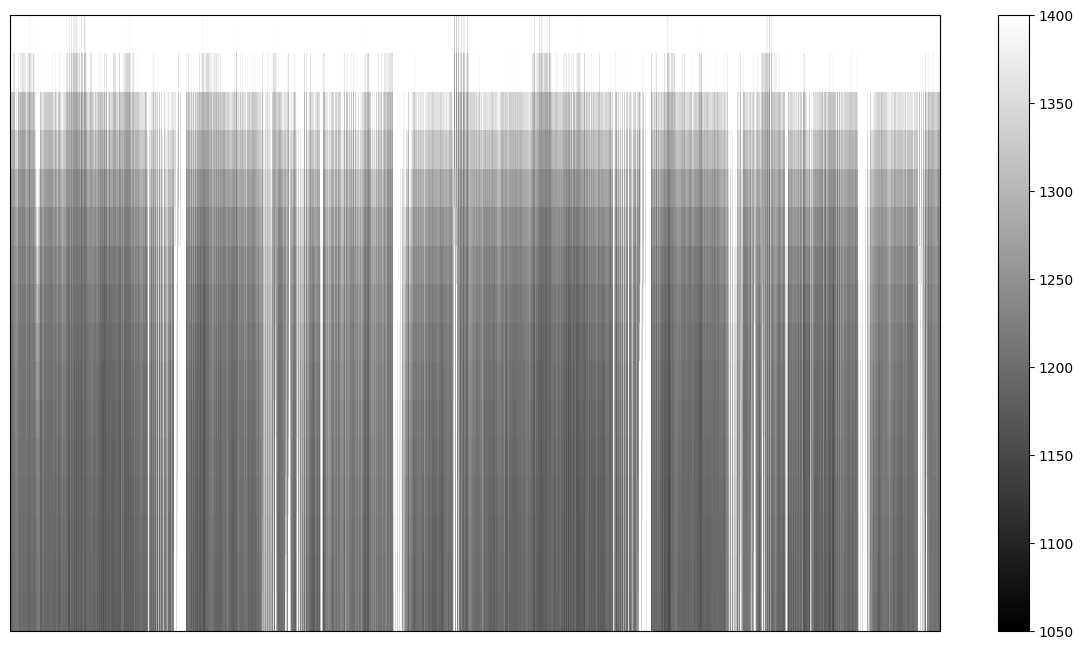

In [27]:
plot_filtered_pcolormesh(mean_T1map, mask_5k, color_range=(1050, 1400))

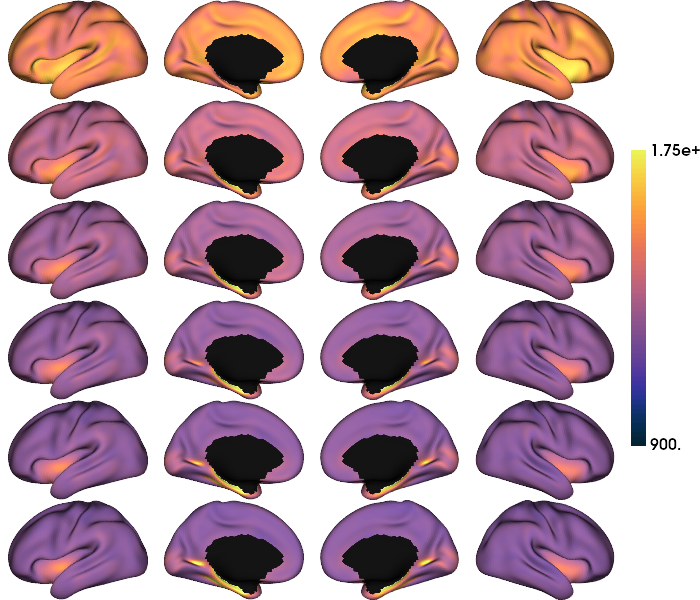

In [9]:
# Extract rows for surface plot
rows_to_extract = [0, 2, 4, 6, 8, 10]
result_3rows = np.flip(mean_T1map, axis=0)[rows_to_extract]

# Calculate the quantiles for the color range
result_3rows[:, mask_5k == False] = np.nan
labels=[str(x)+' mm' for x in [0.0, 0.4, 0.8, 1.2, 1.4]]

# Plot with the new color range
plot_hemispheres(inf_lh, inf_rh, array_name=result_3rows, size=(700, 600), color_bar='right', zoom=1.8, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='cmo.thermal', transparent_bg=True, screenshot=False, color_range=(900,1750))

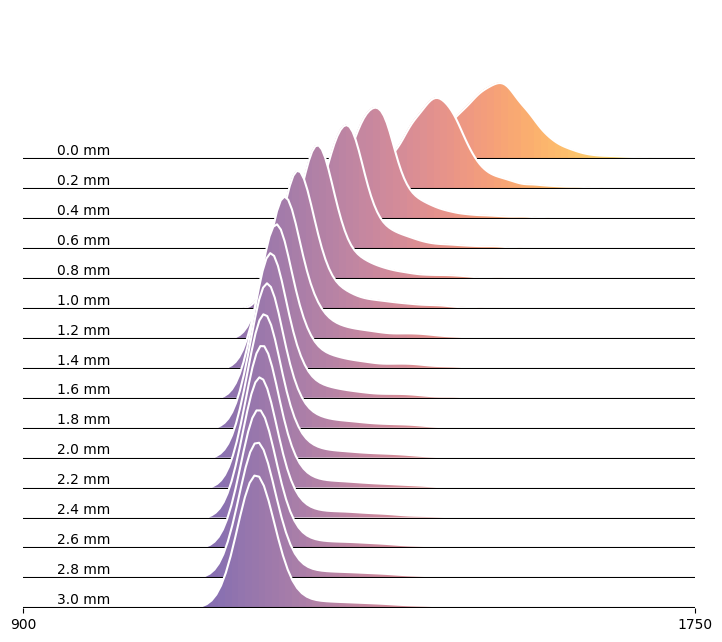

In [16]:
labels = [str(x)+' mm' for x in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]]
flip_img = np.flip(mean_T1map, axis=0)
#log_img = np.log(flip_img)

plot_ridgeplot(matrix=flip_img, matrix_df=labels, Cmap='cmo.thermal', Range=(900, 1750), Xlab="")

### MTsat

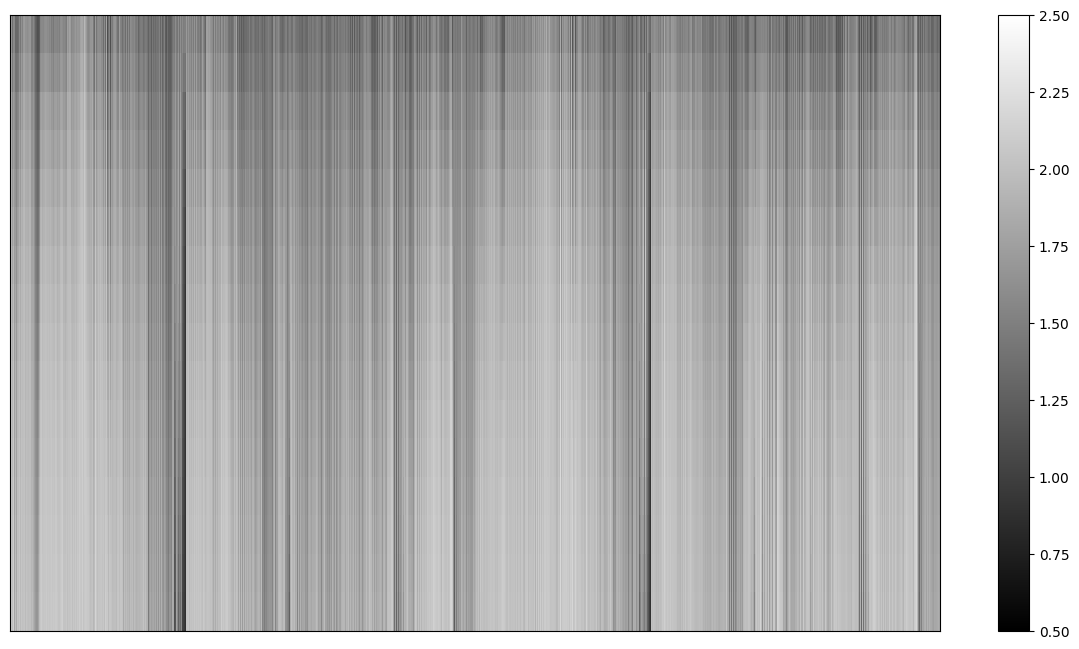

In [28]:
plot_filtered_pcolormesh(mean_MTSAT, mask_5k, color_range=(0.5,2.5))

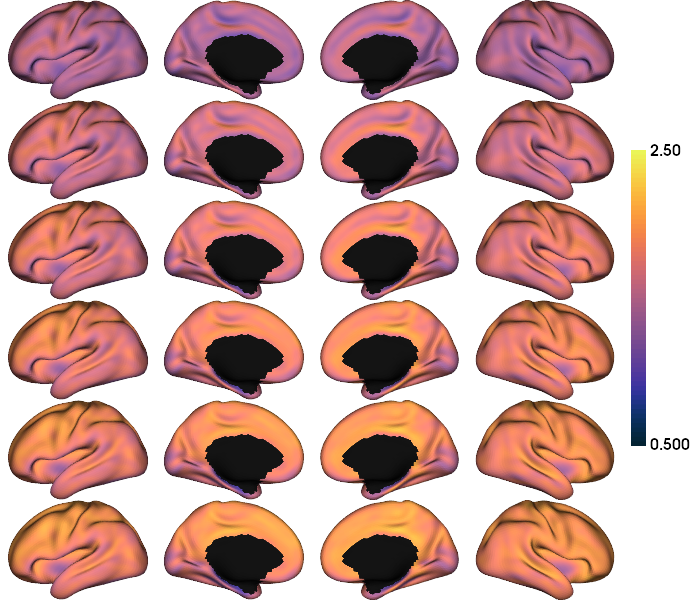

In [17]:
# Extract rows for surface plot
rows_to_extract = [0, 2, 4, 6, 8, 10]
result_3rows = np.flip(mean_MTSAT, axis=0)[rows_to_extract]

# Replace midwall with NaN
result_3rows[:, mask_5k == False] = np.nan

# Create labels for surf plot
labels=[str(x)+' mm' for x in [0.0, 0.4, 0.8, 1.2, 1.4]]

# Plot with the new color range
plot_hemispheres(inf_lh, inf_rh, array_name=result_3rows, size=(700, 600), color_bar='right', zoom=1.8, embed_nb=True, interactive=False, share='both', nan_color=(0, 0, 0, 1), 
                 cmap='cmo.thermal', transparent_bg=True, screenshot=False, color_range=(0.5,2.5))

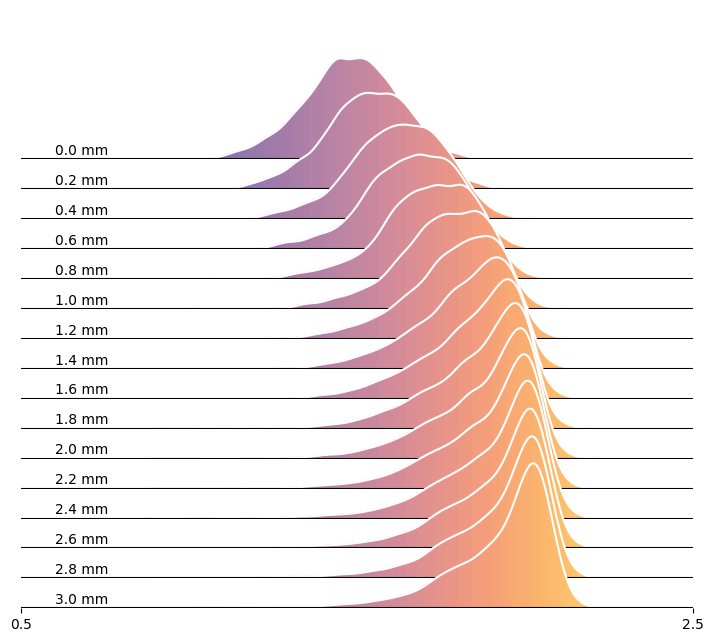

In [18]:
labels = [str(x)+' mm' for x in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]]
flip_img = np.flip(mean_MTSAT, axis=0)

flip_img[:, mask_5k == False] = np.nan

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(flip_img).any(axis=0)
flip_img = flip_img[:, valid_rows]

plot_ridgeplot(matrix=flip_img, matrix_df=labels, Cmap='cmo.thermal', Range=(0.5, 2.5), Xlab="")